In [28]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import librosa.display

from numpy.lib.stride_tricks import as_strided
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np

<h3>Load Audio File</h3>

In [29]:
train_audio_path = '../data/AMHARIC/train/wav/'
samples, sample_rate = librosa.load(train_audio_path+'tr_1_tr01001.wav')
print(samples)
print(sample_rate)

[-0.00502738 -0.00577551 -0.0046026  ... -0.00579655 -0.00516981
  0.        ]
22050


In [30]:
audio, rate=librosa.load(train_audio_path+'tr_1_tr01001.wav', sr=44100)
print(audio)
print(rate)

[-0.00502738 -0.00588078 -0.00577551 ... -0.00516981 -0.00347923
  0.        ]
44100


In [31]:
ipd.Audio(samples, rate=sample_rate)

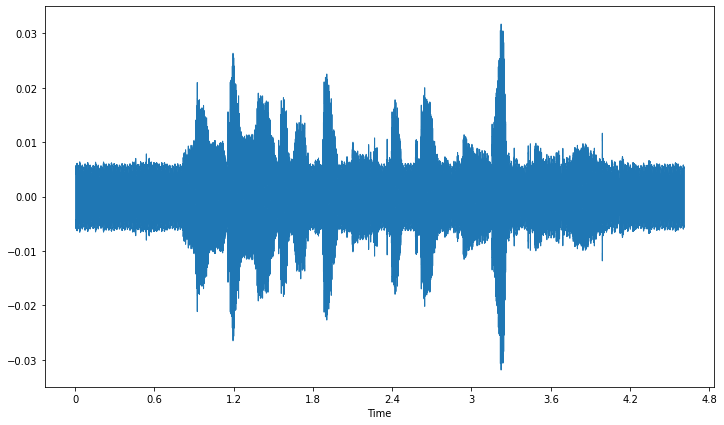

In [32]:
plt.figure(figsize=(12, 7))
librosa.display.waveshow(samples, sr=sample_rate)

In [33]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [34]:
spe_samples,frequency=spectrogram(samples)

In [35]:
frequency

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

In [36]:
spe_samples

array([[1.76332217e-03, 2.75115201e-03, 2.59518971e-03, ...,
        2.30338586e-03, 1.59972883e-03, 2.36620903e-03],
       [8.27526690e-04, 1.48350486e-03, 1.33823861e-03, ...,
        1.21430866e-03, 7.00716316e-04, 1.31378762e-03],
       [2.86930759e-06, 1.92337456e-06, 3.61349402e-08, ...,
        3.54633404e-07, 4.78659698e-06, 5.78052387e-06],
       ...,
       [6.71118643e-17, 4.33052209e-19, 3.63256681e-18, ...,
        1.55272596e-19, 5.21457062e-18, 9.12951220e-20],
       [1.72332657e-16, 2.51864806e-18, 3.12430283e-18, ...,
        6.62812802e-18, 3.57302015e-18, 2.60651919e-18],
       [3.35206898e-17, 1.30404485e-18, 1.55713733e-18, ...,
        5.52245060e-19, 1.04002583e-18, 2.38001449e-19]])

In [37]:
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

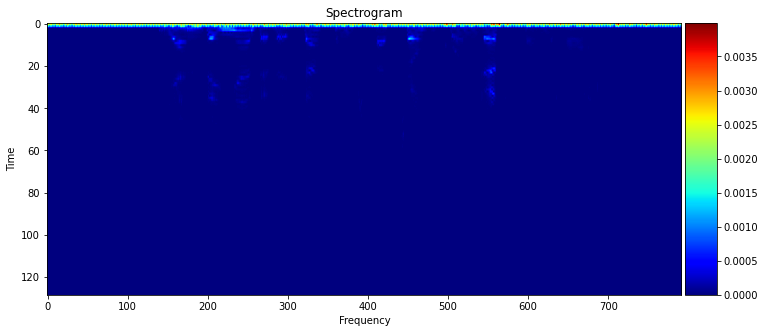

In [38]:
plot_spectrogram_feature(spe_samples)

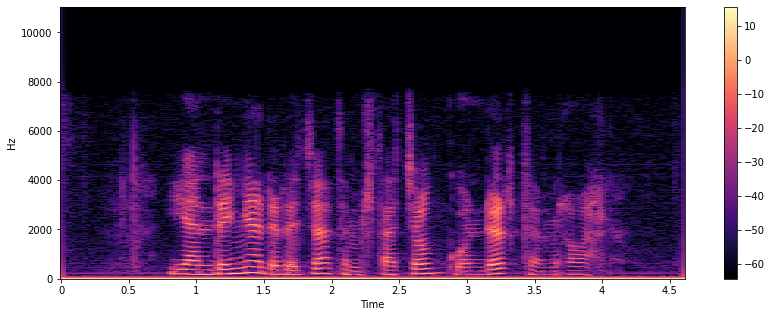

In [39]:
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

<h2>Data Augumentation</h2>
<h3>Time Shifting</h3>

In [40]:
def plot_spec(data:np.array,sr:int) -> None:
  '''
  Function for plotting spectrogram along with amplitude wave graph
  '''

  fig, ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].title.set_text(f'Shfiting the wave by Times {sr/10}')
  ax[0].specgram(data,Fs=2)
  ax[1].set_ylabel('Amplitude')
  ax[1].plot(np.linspace(0,1,len(data)), data)

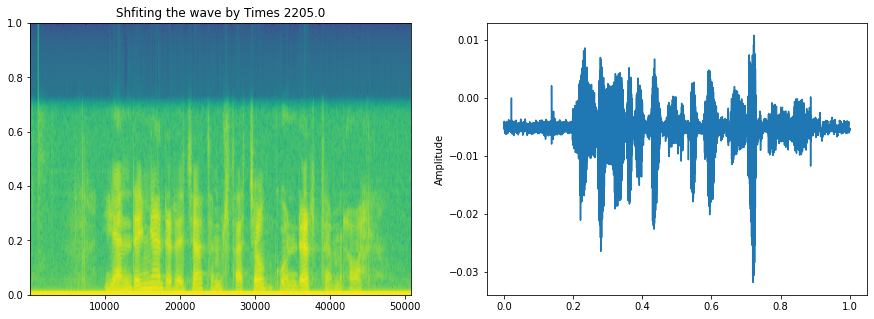

In [41]:
wav_roll = np.roll(samples,int(sample_rate/10))
plot_spec(data=wav_roll,sr=sample_rate)
ipd.Audio(wav_roll,rate=sample_rate)

(20, 199)


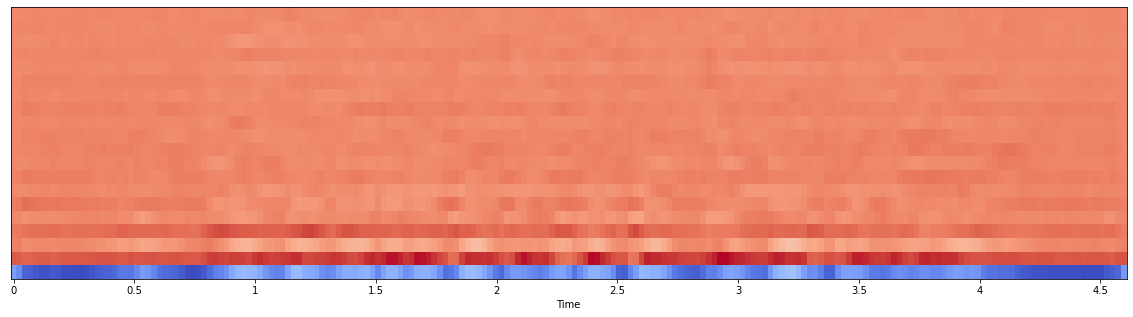

In [42]:
plt.figure(figsize=(20,5))
mfccs = librosa.feature.mfcc(samples, sr=sample_rate)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

<h3>Load Transcript</h3>

In [43]:
def tran_loader(filename):
  name_to_text = {}
  with open (filename, encoding="utf-8") as f:
    f.readline()
    for line in f:
      name=line.split("</s>")[1]
      name=name.replace('(', '')
      name=name.replace(')', '')
      name=name.replace('\n','')
      name=name.replace(' ','')
      text=line.split("</s>")[0]
      text=text.replace("<s>","")
      name_to_text[name]=text
    return name_to_text

In [44]:
transcription=tran_loader("../data/AMHARIC/train/trsTrain.txt")

In [45]:
transcription

{'tr_2_tr01002': ' የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስፖርት ና መጓጓዣ ገንዘብ ተሰጥቷ ቸው መሸኘታቸው ን አመልክቶ በ የ ዞ ናቸው እንደ ደረሱ መቃቋሚያ እንደሚ ሰጣቸው ም አስ ታውቋል ',
 'tr_3_tr01003': ' በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ የ ተገናኙ ት መድን ና ሙገር ሲሚንቶ ሲ ሆኑ በ ውጤቱ ም ሶስት ለ ሶስት ተለያይ ተዋል ',
 'tr_4_tr01004': ' ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው ',
 'tr_5_tr01005': ' ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳጀ ች ',
 'tr_6_tr01006': ' ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያል ተረገጠ ች አገር ኢትዮጵያ ና ት ',
 'tr_7_tr01007': ' እህቶቹ የኤርትራ ዜጐች ና የ ሻእቢያ ደጋፊዎች ናቸው ',
 'tr_8_tr01008': ' እናንተ ም መቀበሪያ እንዳ ታጡ ተጠንቀቁ ',
 'tr_9_tr01009': ' አንቶኔሊ በ አጼ ምንሊክ ፊት የ ፈጸመው ድፍረት በ ኢጣሊያ ን ምክር ቤት አስተ ቸው ',
 'tr_10_tr01010': ' ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎማሲ ያቸው እስራኤል ንም ያስ ወር ፋቸው ጀመር ',
 'tr_11_tr01011': ' ከ የ አቅጣጫ ው እየ ደረሷቸው ያሉ መረጃዎች አሳሳቢ ችግሮች እየ ደረሱ መሆናቸው ን የሚ ጠቁሙ መሆናቸው ን ፕሬዝዳንቱ ተናግረ ዋል ',
 'tr_12_tr01012': ' ከ ማወቁ በፊት እንደ ተበጠበጠ ገበያ እንዳይ በታተን ይህ ነው አጀንዳ ችን ሌላ አጀንዳ የ ለ ንም ',
 'tr_13_tr01013': ' ኢትዮጵያ ም ሰራዊቷ በ ኤርትራ እንደሚ 

In [46]:
def meta_data(trans, path ):
  target=[]
  features=[]
  filenames=[]
  duration_of_recordings=[]
  for k in trans:
    filename=path+k +".wav"
    filenames.append(filename)
    audio, fs = librosa.load(filename, sr=None)
    duration_of_recordings.append(float(len(audio)/fs))

    lable = trans[k]
    target.append(lable)
  return filenames, target,duration_of_recordings

In [25]:
filenames, target,duration_of_recordings= meta_data(transcription,'../data/AMHARIC/train/wav/')

In [26]:
len(filenames)

10874

In [27]:
data=pd.DataFrame({'key': filenames,'text': target, 'duration':duration_of_recordings})
data.head()

,key,text,duration
0,../data/AMHARIC/train/wav/tr_2_tr01002.wav,የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስ...,16.384
1,../data/AMHARIC/train/wav/tr_3_tr01003.wav,በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ...,14.592
2,../data/AMHARIC/train/wav/tr_4_tr01004.wav,ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው,4.736
3,../data/AMHARIC/train/wav/tr_5_tr01005.wav,ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳ...,8.192
4,../data/AMHARIC/train/wav/tr_6_tr01006.wav,ከ ትምክህት እንዳይ ቆጠር ብን እንጂ በ አለም ታሪክ ውስጥ በ ነጮች ያ...,8.704
